**509_Final Project**

Git Hub Link: https://github.com/Shivaay82/509_Project/projects?query=is%3Aopen


Group 9- Shivani Pandey (1821557)

Pleezent Brass (1803833)

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F684%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T021724Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6782e54860b3f182f53ccff204ce385ca4496dd15d36ea128bf27a8c447450cea652d6fe61c27d03e80e567a85a3b42dcd01c397443b05065718b217a3066b6771ae447a574528a78b2d6c2b13502c029c9ff159265b5b78c3698db6436285955e35b41547b6caa3b3f2efbe76e859ab894fae9d781a983507501d7779f83833e05a83ed8f40d4c39048ff5b2f33b900768eefd64f7bc4ec7c11cb8f3ed26022633f3583149e65694e54b362686e02260650eacf3da5a9f6320cdd019f1f4745dcc3b1f0c03486339e09722ac1b97369649c0f90af3eb6363e45ab98f9dcfe2a4f01daabf58c32acd406ef60986a076d30e8daeb28cd1eff1ae4da6479793e91'
INPUT_PATH = '/kaggle/input'
WORKING_PATH = '/kaggle/working'
SYMLINK = 'kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass

try:
    os.symlink(WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(INPUT_PATH, directory)

    try:
        with urlopen(download_url) as file_res, NamedTemporaryFile() as temp_file:
            total_length = file_res.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            downloaded = 0
            data = file_res.read(CHUNK_SIZE)
            while data:
                downloaded += len(data)
                temp_file.write(data)
                progress = int(50 * downloaded / int(total_length))
                sys.stdout.write(f"\r[{'=' * progress}{' ' * (50-progress)}] {downloaded} bytes downloaded")
                sys.stdout.flush()
                data = file_res.read(CHUNK_SIZE)

            if filename.endswith('.zip'):
                with ZipFile(temp_file) as zip_file:
                    zip_file.extractall(destination_path)
            else:
                with tarfile.open(temp_file.name) as tar_file:
                    tar_file.extractall(destination_path)

            print(f'\nDownloaded and uncompressed: {directory}')

    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [2]:
import pandas as pd  # for data analytics
import numpy as np  # for numerical computation
from matplotlib import pyplot as plt, style  # for plotting
import seaborn as sns  # for plotting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix  # for evaluation
import itertools

style.use('ggplot')
np.random.seed(452)

def display_confusion_matrix(conf_matrix, labels, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=0)
    plt.yticks(tick_marks, labels)

    threshold = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

***Information about our Dataset***

Dataset Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

This dataset shows the transactions that took place over a two-day period. Of
the 284,807 transactions, 492 were fraudulent. Because of the extreme imbalance in the dataset, 0.172% of all transactions belong to frauds.

In [3]:
credit_card_data = pd.read_csv('../input/creditcard.csv')#.drop('Time', axis=1)
credit_card_data['Amount'] = np.log(credit_card_data['Amount'] + 1)
credit_card_data['Time'] = np.log(credit_card_data['Time'] + 1)

normal_transactions = credit_card_data[credit_card_data['Class'] == 0]
fraudulent_transactions = credit_card_data[credit_card_data['Class'] == 1]

print(normal_transactions.shape)
print(fraudulent_transactions.shape)

(284315, 31)
(492, 31)


In [33]:
credit_card_data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626,0
2,0.693147,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276,0
3,0.693147,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306,0
4,1.098612,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539,0
5,1.098612,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,1.541159,0
6,1.609438,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,1.790091,0
7,2.079442,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,3.732896,0
8,2.079442,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,4.545420,0
9,2.302585,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,1.543298,0


In [34]:
credit_card_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [38]:
credit_card_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [35]:
credit_card_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,11.252433,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,3.152188,0.001727
std,0.818265,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.656648,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,10.900482,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,1.887070,0.000000
50%,11.346788,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,3.135494,0.000000
75%,11.844539,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,4.358822,0.000000
max,12.059850,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,10.153941,1.000000


In [40]:
credit_card_data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [4]:
from sklearn.model_selection import train_test_split

train_data, normal_test_data, _, _ = train_test_split(normal_transactions, normal_transactions, test_size=.2, random_state=42)
normal_valid_data, normal_test_data, _, _ = train_test_split(normal_test_data, normal_test_data, test_size=.5, random_state=42)
anormal_valid_data, anormal_test_data, _, _ = train_test_split(fraudulent_transactions, fraudulent_transactions, test_size=.5, random_state=42)

train_data = train_data.reset_index(drop=True)
valid_data = pd.concat([normal_valid_data, anormal_valid_data]).sample(frac=1).reset_index(drop=True)
test_data = pd.concat([normal_test_data, anormal_test_data]).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train_data.shape)
print('Proportion of anomaly in training set: %.2f\n' % train_data['Class'].mean())
print('Valid shape: ', valid_data.shape)
print('Proportion of anomaly in validation set: %.2f\n' % valid_data['Class'].mean())
print('Test shape:, ', test_data.shape)
print('Proportion of anomaly in test set: %.2f\n' % test_data['Class'].mean())

Train shape:  (227452, 31)
Proportion of anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion of anomaly in validation set: 0.01

Test shape:,  (28678, 31)
Proportion of anomaly in test set: 0.01



**Technique-1 : Gaussian Model Based**

Setting up a Gaussian model for anomaly detection in credit card transactions. It calculates the mean values and covariance matrix of the features from the training data, excluding the 'Class' column.

In [41]:
from scipy.stats import multivariate_normal

# Import the multivariate_normal distribution from scipy.stats

mean_values = train_data.drop('Class', axis=1).mean(axis=0).values
# Calculate the mean values of the features from the training data, excluding the 'Class' column

covariance_matrix = train_data.drop('Class', axis=1).cov().values
# Calculate the covariance matrix of the features from the training data, excluding the 'Class' column

gaussian_model = multivariate_normal(cov=covariance_matrix, mean=mean_values, allow_singular=True)
# Create a multivariate normal distribution object with the calculated mean values and covariance matrix
# The 'allow_singular=True' parameter allows for singular covariance matrices

print(np.median(gaussian_model.logpdf(valid_data[valid_data['Class'] == 0].drop('Class', axis=1).values)))
# Print the median of the log probability density function (log-pdf) for normal transactions in the validation data
# The log-pdf is calculated using the multivariate normal distribution object

print(np.median(gaussian_model.logpdf(valid_data[valid_data['Class'] == 1].drop('Class', axis=1).values)))
# Print the median of the log probability density function (log-pdf) for fraudulent transactions in the validation data
# The log-pdf is calculated using the multivariate normal distribution object

-32.8190882887133
-661.9006173762136


Evaluating the performance of the Gaussian model for anomaly detection in credit card transactions using different threshold values. It generates an array of threshold values between -1000 and -10, with a total of 150 values

In [42]:
threshold_values = np.linspace(-1000, -10, 150)
# Create an array of 150 threshold values between -1000 and -10 using np.linspace

evaluation_scores = []
# Initialize an empty list to store evaluation scores

for threshold in threshold_values:
    predicted_labels = (gaussian_model.logpdf(valid_data.drop('Class', axis=1).values) < threshold).astype(int)
    # For each threshold value, calculate the log probability density function (log-pdf) using the Gaussian model
    # Compare the log-pdf values with the threshold to generate predicted labels (0 or 1)
    # Convert the boolean values to integers (0 or 1)

    evaluation_scores.append([
        recall_score(y_pred=predicted_labels, y_true=valid_data['Class'].values),
        precision_score(y_pred=predicted_labels, y_true=valid_data['Class'].values),
        fbeta_score(y_pred=predicted_labels, y_true=valid_data['Class'].values, beta=2)
    ])
    # For each threshold value, calculate the recall, precision, and F2 score (with beta=2)
    # Append these scores as a list to the evaluation_scores list

evaluation_scores = np.array(evaluation_scores)
# Convert the evaluation_scores list to a NumPy array for easier manipulation

print(evaluation_scores[:, 2].max(), evaluation_scores[:, 2].argmax())
# Print the maximum value in the third column (F2 score) and its index
# The index corresponds to the threshold value that produced the maximum F2 score

0.749395648670427 110


 Visualize the recall, precision, and F2 scores for different threshold values. This visualization helps to understand how the recall, precision, and F2 scores vary across different threshold values, which can aid in selecting an appropriate threshold that balances these metrics for the anomaly detection task.

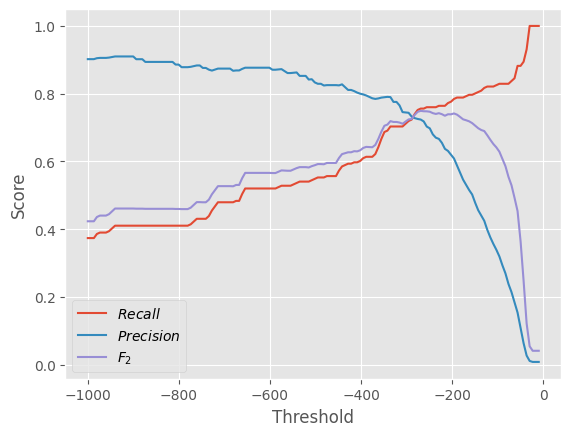

In [43]:
plt.plot(threshold_values, evaluation_scores[:, 0], label='$Recall$')
# Plot the recall scores against the threshold values
# The label '$Recall$' will be displayed in the legend with mathematical formatting

plt.plot(threshold_values, evaluation_scores[:, 1], label='$Precision$')
# Plot the precision scores against the threshold values
# The label '$Precision$' will be displayed in the legend with mathematical formatting

plt.plot(threshold_values, evaluation_scores[:, 2], label='$F_2$')
# Plot the F2 scores against the threshold values
# The label '$F_2$' will be displayed in the legend with mathematical formatting

plt.ylabel('Score')
# Set the label for the y-axis as 'Score'

plt.xlabel('Threshold')
# Set the label for the x-axis as 'Threshold'

plt.legend(loc='best')
# Display a legend with the labels for each line
# The location of the legend will be automatically determined to avoid overlapping with the plot

plt.show()
# Display the plot

The confusion matrix provides a visual representation of the model's performance, showing the number of true positives, true negatives, false positives, and false negatives. It helps evaluate how well the model is able to classify normal and anomalous (fraudulent) transactions based on the optimal threshold value.

Final threshold: -269.1275167785235
Test Recall Score: 0.793
Test Precision Score: 0.701
Test F2 Score: 0.773
Confusion matrix, without normalization
[[28349    83]
 [   51   195]]


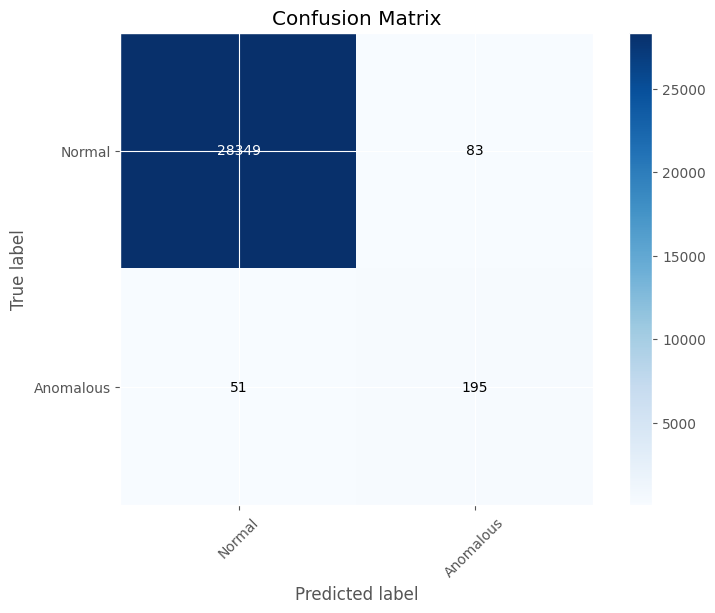

In [44]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, fbeta_score
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Find the optimal threshold value
optimal_threshold = threshold_values[np.argmax(evaluation_scores[:, 2])]

# Generate predicted labels for the test data using the optimal threshold
predicted_test_labels = (gaussian_model.logpdf(test_data.drop('Class', axis=1).values) < optimal_threshold).astype(int)

# Calculate evaluation metrics on the test data
recall = recall_score(y_pred=predicted_test_labels, y_true=test_data['Class'].values)
precision = precision_score(y_pred=predicted_test_labels, y_true=test_data['Class'].values)
f2 = fbeta_score(y_pred=predicted_test_labels, y_true=test_data['Class'].values, beta=2)

# Print the optimal threshold and evaluation metrics
print(f"Final threshold: {optimal_threshold}")
print(f"Test Recall Score: {recall:.3f}")
print(f"Test Precision Score: {precision:.3f}")
print(f"Test F2 Score: {f2:.3f}")

# Calculate and plot the confusion matrix
confusion_mat = confusion_matrix(test_data['Class'].values, predicted_test_labels)
plot_confusion_matrix(confusion_mat, classes=['Normal', 'Anomalous'], title='Confusion Matrix')

**Technique-2: Histogram Based Classification**


Visualize the differences in the distributions of selected features between normal and anomalous (fraudulent) transactions, which can provide insights into the characteristics of fraudulent behavior and aid in the development of effective fraud detection models.

<ipython-input-45-5577a01298af>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 1], shade=True, label='Anomalous')
<ipython-input-45-5577a01298af>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 0], shade=True, label='Normal')


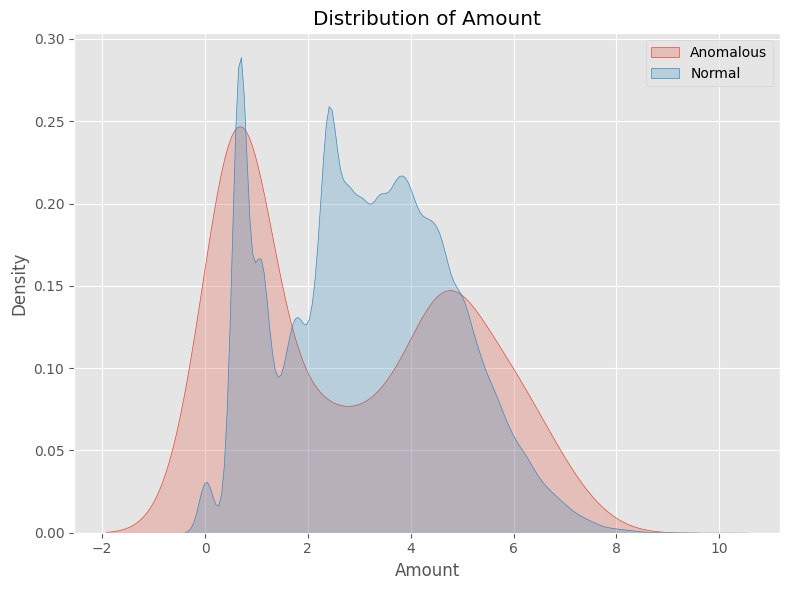

<ipython-input-45-5577a01298af>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 1], shade=True, label='Anomalous')
<ipython-input-45-5577a01298af>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 0], shade=True, label='Normal')


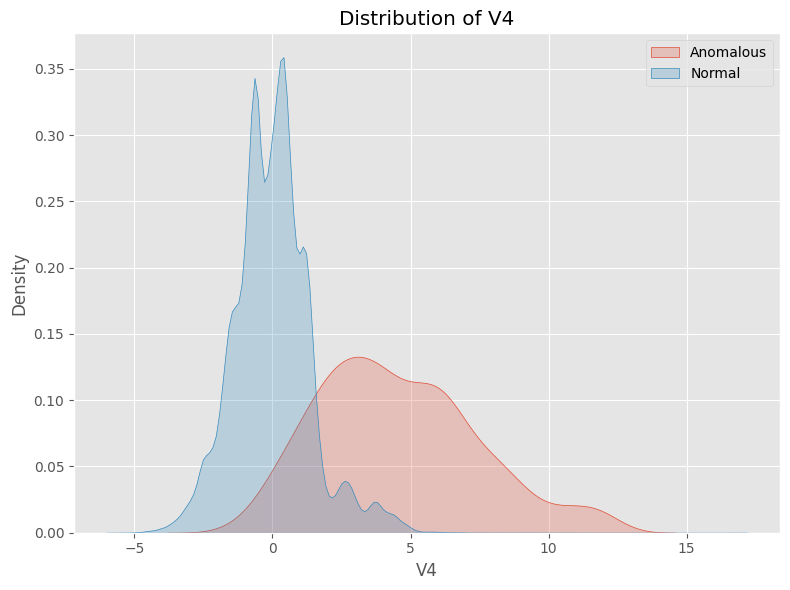

<ipython-input-45-5577a01298af>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 1], shade=True, label='Anomalous')
<ipython-input-45-5577a01298af>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 0], shade=True, label='Normal')


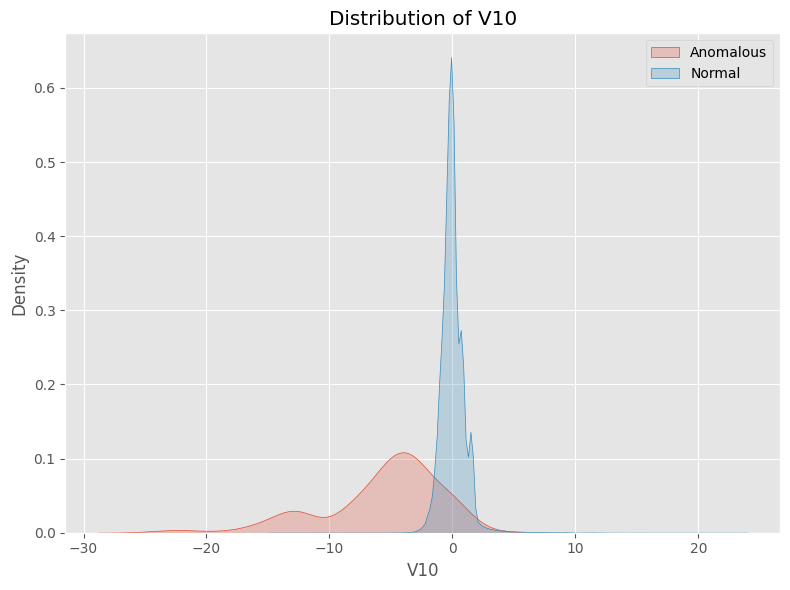

<ipython-input-45-5577a01298af>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 1], shade=True, label='Anomalous')
<ipython-input-45-5577a01298af>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 0], shade=True, label='Normal')


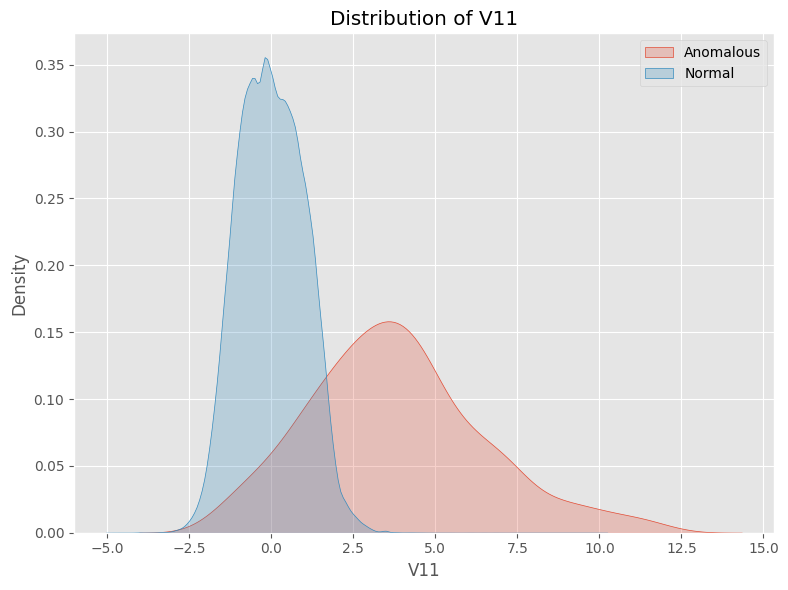

<ipython-input-45-5577a01298af>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 1], shade=True, label='Anomalous')
<ipython-input-45-5577a01298af>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 0], shade=True, label='Normal')


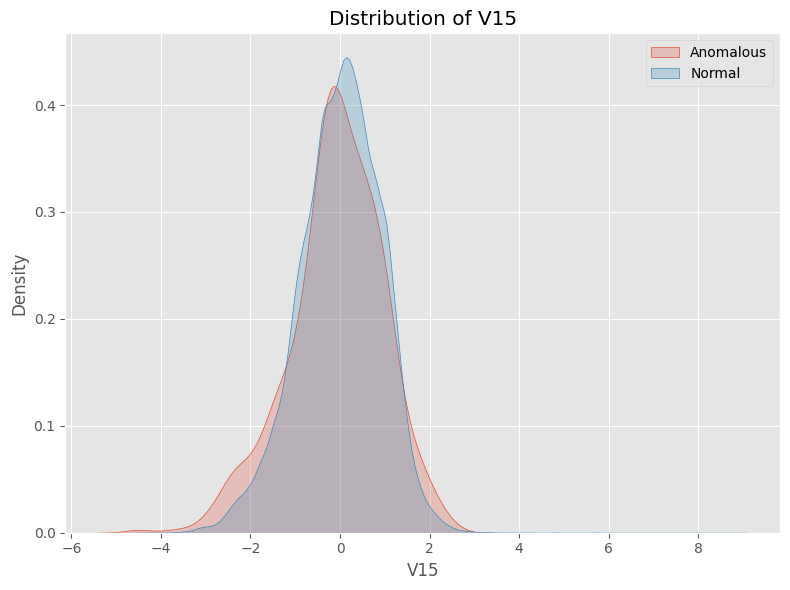

In [45]:
features_to_plot = ['Amount', 'V4', 'V10', 'V11', 'V15']
# Create a list of feature names to plot their distributions

for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    # Create a new figure with a specified size for each feature

    # Plot the distribution for anomalous transactions
    sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 1], shade=True, label='Anomalous')
    # Use seaborn's kdeplot to plot the kernel density estimate (KDE) for the anomalous transactions
    # shade=True fills the area under the KDE curve
    # label='Anomalous' sets the label for the legend

    # Plot the distribution for normal transactions
    sns.kdeplot(credit_card_data[feature][credit_card_data.Class == 0], shade=True, label='Normal')
    # Use seaborn's kdeplot to plot the kernel density estimate (KDE) for the normal transactions
    # shade=True fills the area under the KDE curve
    # label='Normal' sets the label for the legend

    plt.xlabel(feature)
    # Set the label for the x-axis as the feature name

    plt.ylabel('Density')
    # Set the label for the y-axis as 'Density'

    plt.title(f'Distribution of {feature}')
    # Set the title of the plot as 'Distribution of <feature_name>'

    plt.legend(loc='upper right')
    # Display a legend in the upper right corner of the plot

    plt.tight_layout()
    # Adjust the spacing between subplots to prevent overlapping

    plt.show()
    # Display the plot

The idea behind this approach is that normal observations should have higher scores (higher bin heights) compared to anomalous observations, as they are more likely to fall within the common bins. By comparing the scores for normal and anomalous observations, a threshold can be determined to classify new observations as normal or anomalous based on their scores.

In [46]:
import numpy as np

class HistogramModel:
    def __init__(self, num_bins=50):
        self.num_bins = num_bins
        self.bin_heights = None
        self.bin_edges = None

    def fit(self, X):
        bin_heights_list = []
        bin_edges_list = []

        for feature in X.T:
            heights, edges = np.histogram(feature, bins=self.num_bins)
            bin_heights_list.append(heights)
            bin_edges_list.append(edges)

        self.bin_heights = np.array(bin_heights_list)
        self.bin_edges = np.array(bin_edges_list)

    def predict(self, X):
        predictions = []

        for observation in X:
            observation_scores = []

            for feature_index, feature_value in enumerate(observation):
                bin_index = np.searchsorted(self.bin_edges[feature_index], feature_value) - 1
                bin_index = max(0, min(bin_index, self.num_bins - 1))  # Ensure bin_index is within valid range
                observation_scores.append(self.bin_heights[feature_index, bin_index])

            predictions.append(np.mean(observation_scores))

        return np.array(predictions)

# Create an instance of the histogram model
histogram_model = HistogramModel()

# Fit the model on the training data
histogram_model.fit(train_data.drop('Class', axis=1).values)

# Predict scores for normal and anomalous observations in the validation set
normal_scores = histogram_model.predict(valid_data[valid_data['Class'] == 0].drop('Class', axis=1).values)
anomalous_scores = histogram_model.predict(valid_data[valid_data['Class'] == 1].drop('Class', axis=1).values)

# Print the median scores for normal and anomalous observations
print(np.median(normal_scores))
print(np.median(anomalous_scores))

67667.86666666667
30645.86666666667


This can be used to select an appropriate threshold that balances the trade-off between recall (detecting anomalies) and precision (minimizing false positives) based on the specific requirements of the anomaly detection task.

In [17]:
def evaluate_model(model, validation_data, thresholds):
    y_true = validation_data['Class'].values
    y_pred_score = model.predict(validation_data.drop('Class', axis=1).values)

    evaluation_scores = []

    for threshold in thresholds:
        y_pred = np.where(y_pred_score < threshold, 1, 0)

        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f2_score = fbeta_score(y_true, y_pred, beta=2)

        evaluation_scores.append([recall, precision, f2_score])

    return np.array(evaluation_scores)

# Define the threshold range
threshold_range = np.linspace(10000, 80000, 100)

# Evaluate the model for different thresholds
scores_array = evaluate_model(histogram_model, valid_data, threshold_range)

This visualization allows you to observe how the recall, precision, and F2 scores vary across different threshold values. By analyzing the behavior of these scores, you can select an appropriate threshold that strikes a balance between capturing anomalies (high recall) and minimizing false positives (high precision) based on the specific requirements of the anomaly detection task.

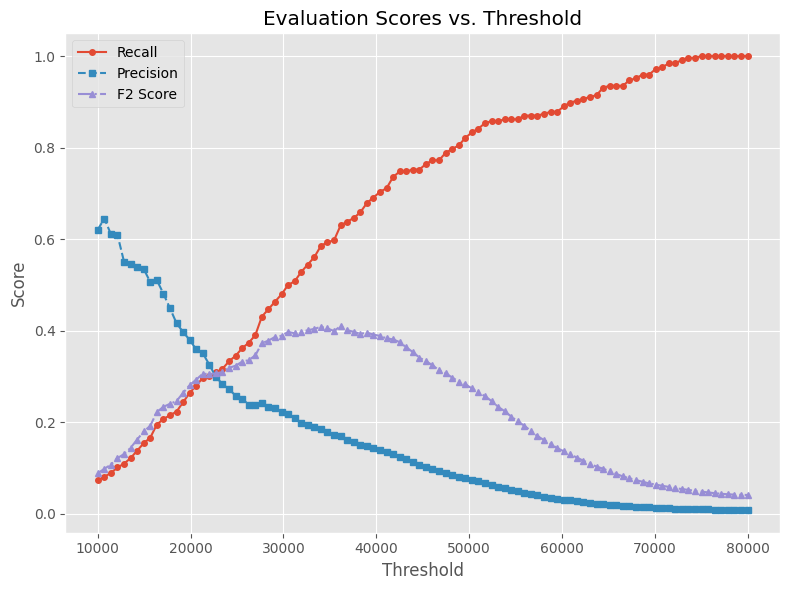

In [18]:
import matplotlib.pyplot as plt

# Extract the individual scores from the scores_array
recall_scores = scores_array[:, 0]
precision_scores = scores_array[:, 1]
f2_scores = scores_array[:, 2]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the scores against the threshold range
ax.plot(threshold_range, recall_scores, label='Recall', linestyle='-', marker='o', markersize=4)
ax.plot(threshold_range, precision_scores, label='Precision', linestyle='--', marker='s', markersize=4)
ax.plot(threshold_range, f2_scores, label='F2 Score', linestyle='-.', marker='^', markersize=4)

# Set the labels and title
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Evaluation Scores vs. Threshold')

# Add a legend
ax.legend(loc='best')

# Adjust the layout and display the plot
fig.tight_layout()
plt.show()

Visualizing the confusion matrix to understand the model's predictions better.

Optimal Threshold: 36162
Test Recall: 0.646
Test Precision: 0.170
Test F2 Score: 0.415
Confusion matrix, without normalization
[[27658   774]
 [   87   159]]


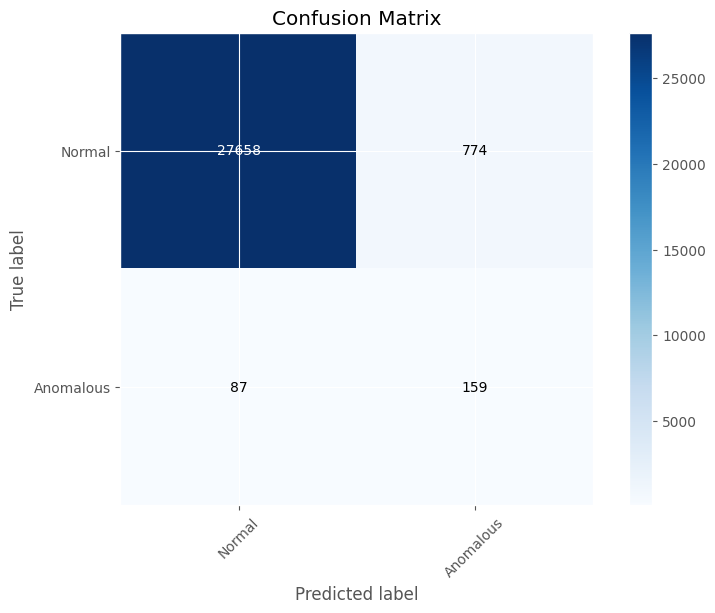

In [19]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, fbeta_score, confusion_matrix

# Find the index of the maximum F2 score
max_f2_index = np.argmax(scores_array[:, 2])

# Get the corresponding optimal threshold
optimal_threshold = threshold_range[max_f2_index]

# Make predictions on the test set using the optimal threshold
test_scores = histogram_model.predict(test_data.drop('Class', axis=1).values)
test_predictions = np.where(test_scores < optimal_threshold, 1, 0)

# Calculate evaluation metrics on the test set
test_recall = recall_score(test_data['Class'].values, test_predictions)
test_precision = precision_score(test_data['Class'].values, test_predictions)
test_f2 = fbeta_score(test_data['Class'].values, test_predictions, beta=2)

# Print the evaluation metrics
print(f"Optimal Threshold: {optimal_threshold:.0f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test F2 Score: {test_f2:.3f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(test_data['Class'].values, test_predictions)
plot_confusion_matrix(conf_matrix, classes=['Normal', 'Anomalous'], title='Confusion Matrix')

**Technique-3: Cluster Based**

The optimal threshold can be selected based on the maximum F2 score or by considering the trade-off between recall and precision based on the specific requirements of the anomaly detection task.

Normal Scores: 13.2627
Anomaly Scores: -316.1647
Maximum F2 Score: 0.7502
Index of Maximum F2 Score: 77


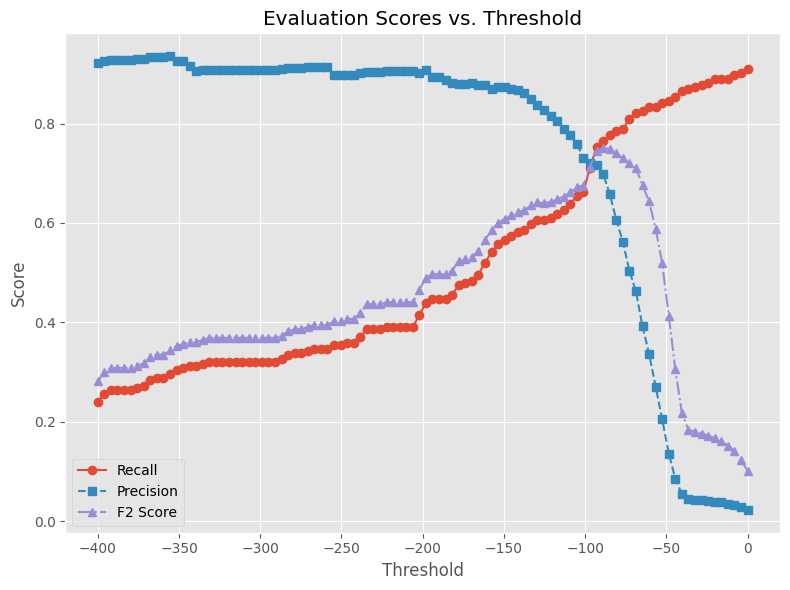

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import recall_score, precision_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt

# Train the Gaussian Mixture Model (GMM)
n_components = 3
n_init = 4
random_state = 452
gmm_model = GaussianMixture(n_components=n_components, n_init=n_init, random_state=random_state)
gmm_model.fit(train_data.drop('Class', axis=1).values)

# Evaluate the GMM on the validation set
normal_scores = gmm_model.score(valid_data[valid_data['Class'] == 0].drop('Class', axis=1).values)
anomaly_scores = gmm_model.score(valid_data[valid_data['Class'] == 1].drop('Class', axis=1).values)
print(f"Normal Scores: {normal_scores:.4f}")
print(f"Anomaly Scores: {anomaly_scores:.4f}")

# Calculate evaluation scores for different thresholds
threshold_range = np.linspace(-400, 0, 100)
validation_scores = gmm_model.score_samples(valid_data.drop('Class', axis=1).values)
evaluation_scores = []

for threshold in threshold_range:
    predicted_labels = np.where(validation_scores < threshold, 1, 0)
    recall = recall_score(valid_data['Class'].values, predicted_labels)
    precision = precision_score(valid_data['Class'].values, predicted_labels)
    f2_score = fbeta_score(valid_data['Class'].values, predicted_labels, beta=2)
    evaluation_scores.append([recall, precision, f2_score])

evaluation_scores = np.array(evaluation_scores)
max_f2_score = evaluation_scores[:, 2].max()
max_f2_score_index = evaluation_scores[:, 2].argmax()
print(f"Maximum F2 Score: {max_f2_score:.4f}")
print(f"Index of Maximum F2 Score: {max_f2_score_index}")

# Plot the evaluation scores
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(threshold_range, evaluation_scores[:, 0], label='Recall', linestyle='-', marker='o')
ax.plot(threshold_range, evaluation_scores[:, 1], label='Precision', linestyle='--', marker='s')
ax.plot(threshold_range, evaluation_scores[:, 2], label='F2 Score', linestyle='-.', marker='^')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Evaluation Scores vs. Threshold')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

Visualizing the confusion matrix to understand the model's predictions better

Optimal Threshold: -88.8889
Test Recall: 0.793
Test Precision: 0.652
Test F2 Score: 0.760
Confusion matrix, without normalization
[[28328   104]
 [   51   195]]


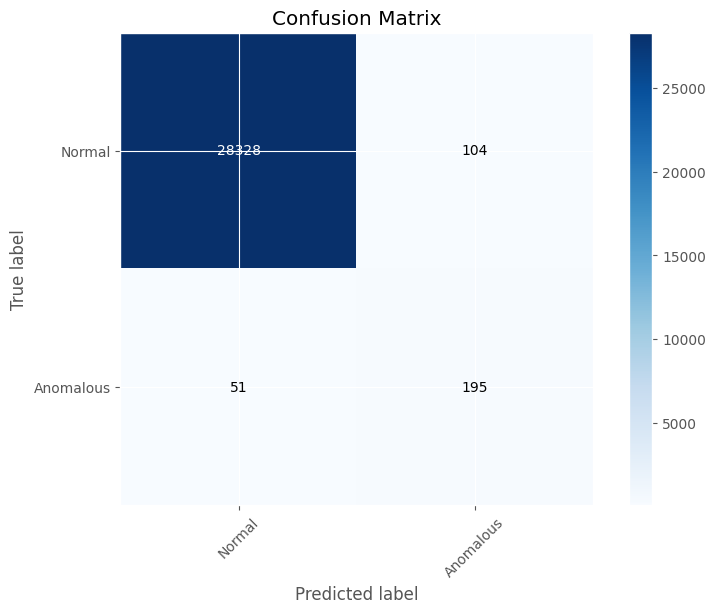

In [21]:
# Determine the optimal threshold based on the maximum F2 score
optimal_threshold = threshold_range[np.argmax(evaluation_scores[:, 2])]

# Make predictions on the test set using the optimal threshold
test_scores = gmm_model.score_samples(test_data.drop('Class', axis=1).values)
test_predictions = np.where(test_scores < optimal_threshold, 1, 0)

# Calculate evaluation metrics on the test set
test_recall = recall_score(test_data['Class'].values, test_predictions)
test_precision = precision_score(test_data['Class'].values, test_predictions)
test_f2_score = fbeta_score(test_data['Class'].values, test_predictions, beta=2)

# Print the evaluation metrics
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test F2 Score: {test_f2_score:.3f}")

# Calculate and plot the confusion matrix
confusion_mat = confusion_matrix(test_data['Class'].values, test_predictions)
plot_confusion_matrix(confusion_mat, classes=['Normal', 'Anomalous'], title='Confusion Matrix')

**Technique-4: Tree Based**

how to train an Isolation Forest model for anomaly detection, evaluate its performance on a validation dataset using various metrics (recall, precision, and F2 score), and visualize the evaluation scores across different threshold values.

Mean Decision Function Score for Normal Samples: 0.1502
Mean Decision Function Score for Anomaly Samples: -0.0535
Maximum F2 Score: 0.6757
Index of Maximum F2 Score: 118


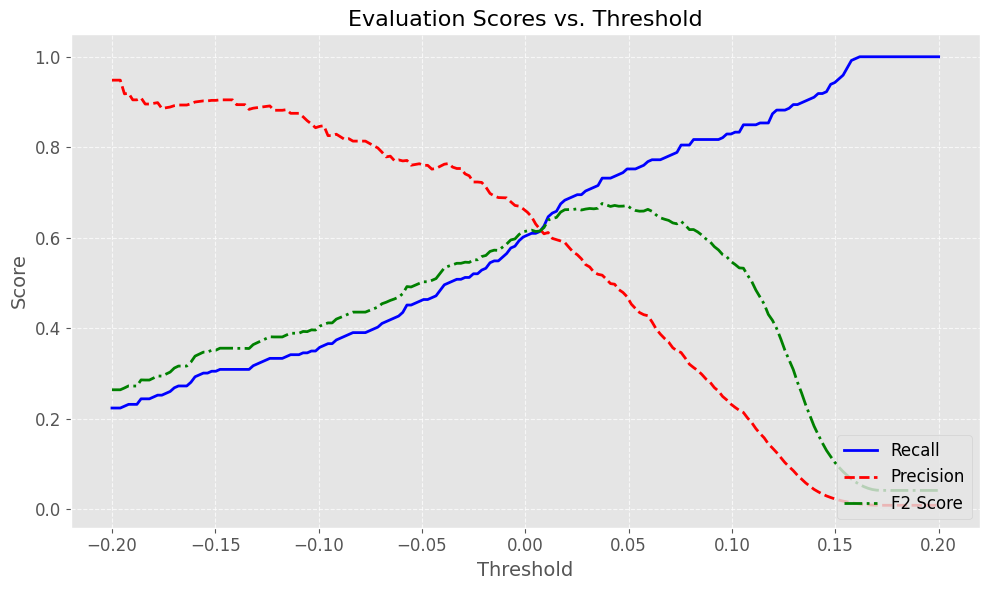

In [22]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, precision_score, fbeta_score
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(452)

# Initialize and train the Isolation Forest model
isolation_forest = IsolationForest(random_state=42, n_jobs=4, max_samples=train_data.shape[0],
                                    bootstrap=True, n_estimators=50)
isolation_forest.fit(train_data.drop('Class', axis=1).values)

# Evaluate the model on the validation set
normal_scores = isolation_forest.decision_function(valid_data[valid_data['Class'] == 0].drop('Class', axis=1).values).mean()
anomaly_scores = isolation_forest.decision_function(valid_data[valid_data['Class'] == 1].drop('Class', axis=1).values).mean()
print(f"Mean Decision Function Score for Normal Samples: {normal_scores:.4f}")
print(f"Mean Decision Function Score for Anomaly Samples: {anomaly_scores:.4f}")

# Define threshold range and calculate evaluation scores
threshold_vals = np.linspace(-0.2, 0.2, 200)
validation_scores = isolation_forest.decision_function(valid_data.drop('Class', axis=1).values)
eval_scores = []

for threshold in threshold_vals:
    predicted_labels = np.where(validation_scores < threshold, 1, 0)
    recall = recall_score(valid_data['Class'].values, predicted_labels)
    precision = precision_score(valid_data['Class'].values, predicted_labels)
    f2_score = fbeta_score(valid_data['Class'].values, predicted_labels, beta=2)
    eval_scores.append([recall, precision, f2_score])

eval_scores = np.array(eval_scores)
max_f2_score = eval_scores[:, 2].max()
max_f2_score_index = eval_scores[:, 2].argmax()
print(f"Maximum F2 Score: {max_f2_score:.4f}")
print(f"Index of Maximum F2 Score: {max_f2_score_index}")

# Plot the evaluation scores with improvements
plt.figure(figsize=(10, 6))
plt.plot(threshold_vals, eval_scores[:, 0], label='Recall', linestyle='-', linewidth=2, color='blue')
plt.plot(threshold_vals, eval_scores[:, 1], label='Precision', linestyle='--', linewidth=2, color='red')
plt.plot(threshold_vals, eval_scores[:, 2], label='F2 Score', linestyle='-.', linewidth=2, color='green')
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Evaluation Scores vs. Threshold', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Visualize confusion matrix

Optimal Threshold: 0.0372
Test Recall: 0.736
Test Precision: 0.523
Test F2 Score: 0.680


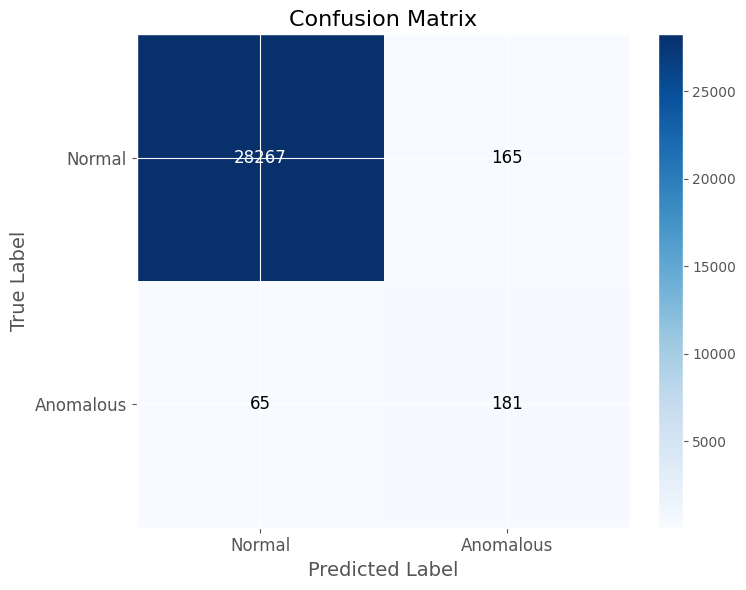

In [23]:
# Determine the optimal threshold based on the maximum F2 score
optimal_threshold = threshold_vals[np.argmax(eval_scores[:, 2])]

# Make predictions on the test set using the optimal threshold
test_scores = isolation_forest.decision_function(test_data.drop('Class', axis=1).values)
test_predictions = np.where(test_scores < optimal_threshold, 1, 0)

# Calculate evaluation metrics on the test set
test_recall = recall_score(test_data['Class'].values, test_predictions)
test_precision = precision_score(test_data['Class'].values, test_predictions)
test_f2_score = fbeta_score(test_data['Class'].values, test_predictions, beta=2)

# Print the evaluation metrics
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test F2 Score: {test_f2_score:.3f}")

# Calculate and plot the confusion matrix
confusion_mat = confusion_matrix(test_data['Class'].values, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = np.arange(len(['Normal', 'Anomalous']))
plt.xticks(tick_marks, ['Normal', 'Anomalous'], fontsize=12)
plt.yticks(tick_marks, ['Normal', 'Anomalous'], fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
for i, j in np.ndindex(confusion_mat.shape):
    plt.text(j, i, confusion_mat[i, j], ha='center', va='center', fontsize=12,
             color='white' if confusion_mat[i, j] > confusion_mat.max() / 2 else 'black')
plt.tight_layout()
plt.show()

Neural Based Techniques

The input features and target labels, respectively, for the randomly sampled subset of 2000 credit card transactions.

In [24]:
import pandas as pd

non_fraud = credit_card_data[credit_card_data['Class'] == 0]
fraud = credit_card_data[credit_card_data['Class'] == 1]

df = pd.concat([non_fraud, fraud], ignore_index=True).sample(2000).reset_index(drop=True)
X = df.drop(['Class'], axis=1).values
Y = df["Class"].values

The autoencoder architecture defined in this code consists of an input layer, an encoding section that compresses the input data into a lower-dimensional representation, a decoding section that reconstructs the input data from the compressed representation, and an output layer that produces the reconstructed input.

During training, the autoencoder learns to minimize the reconstruction error between the input data and the output of the network. This process allows the autoencoder to learn a compressed representation of the input data that captures the most important features or patterns. Autoencoders can be used for various tasks, such as dimensionality reduction, data denoising, and anomaly detection.

In [25]:
from keras.layers import Input, Dense
from keras import regularizers

## Input Layer
in_layer = Input(shape=(X.shape[1],))

## Encoding Section
encode = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(in_layer)
encode = Dense(50, activation='relu')(encode)

## Decoding Section
decode = Dense(50, activation='tanh')(encode)
decode = Dense(100, activation='tanh')(decode)

## Output Layer
out_layer = Dense(X.shape[1], activation='relu')(decode)

After executing this code, the Auto_encoder variable will contain the compiled autoencoder model, ready for training. The model can be trained on the input data using the fit method, and the trained model can be used for various tasks, such as dimensionality reduction, data denoising, or anomaly detection.

It's important to note that this code assumes that the in_layer and out_layer variables are defined previously, representing the input layer and the output layer of the autoencoder, respectively. These layers should be defined based on the specific architecture of the autoencoder, as shown in the previous code snippets.

In [26]:
from keras.models import Model, Sequential

# Create the autoencoder model
Auto_encoder = Model(in_layer, out_layer)

# Compile the autoencoder model
Auto_encoder.compile(optimizer="adadelta", loss="mse")

Scaling the input features is a common preprocessing step in machine learning, as it ensures that features with different scales or units do not dominate the learning process. The MinMaxScaler is one of the scaling techniques that rescales the features to a common range, typically between 0 and 1.

Separating the normal and fraudulent transactions after scaling can be useful for various purposes, such as analyzing the distributions of the scaled features for each class, visualizing the data, or performing separate preprocessing steps for each class if needed.

After executing this code, the variables x_norm and x_fraud will contain the scaled input features for normal and fraudulent transactions, respectively, which can be used for further analysis or modeling tasks.

In [27]:
from sklearn import preprocessing

# Split the data into input features (x) and target labels (y)
x = credit_card_data.drop(["Class"], axis=1)
y = credit_card_data["Class"].values


# Scale the input features using MinMaxScaler
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)

# Separate the scaled input features into normal and fraudulent transactions
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

By training the autoencoder on a subset of normal transactions, the model will learn to reconstruct these normal transactions accurately. The reconstruction error for normal transactions should be relatively small, as the autoencoder is trained to reproduce the input data faithfully.

During the training process, the autoencoder will learn a compressed representation (encoding) of the input data in the hidden layers, which captures the essential features or patterns of the normal transactions. This learned representation can then be used for various tasks, such as anomaly detection, where anomalous (fraudulent) transactions are expected to have higher reconstruction errors compared to normal transactions.

After training, the autoencoder model can be used to reconstruct both normal and fraudulent transactions, and the reconstruction errors can be analyzed to identify potential anomalies or fraudulent activities.

In [28]:
Auto_encoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size = 230, epochs = 40,
                shuffle = True, validation_split = 0.20);

Epoch 1/40
7/7 [==============================] - 4s 107ms/step - loss: 0.2894 - val_loss: 0.2918
Epoch 2/40
7/7 [==============================] - 0s 9ms/step - loss: 0.2890 - val_loss: 0.2915
Epoch 3/40
7/7 [==============================] - 0s 9ms/step - loss: 0.2886 - val_loss: 0.2911
Epoch 4/40
7/7 [==============================] - 0s 13ms/step - loss: 0.2883 - val_loss: 0.2908
Epoch 5/40
7/7 [==============================] - 0s 9ms/step - loss: 0.2879 - val_loss: 0.2904
Epoch 6/40
7/7 [==============================] - 0s 12ms/step - loss: 0.2875 - val_loss: 0.2900
Epoch 7/40
7/7 [==============================] - 0s 9ms/step - loss: 0.2871 - val_loss: 0.2896
Epoch 8/40
7/7 [==============================] - 0s 13ms/step - loss: 0.2867 - val_loss: 0.2892
Epoch 9/40
7/7 [==============================] - 0s 14ms/step - loss: 0.2863 - val_loss: 0.2887
Epoch 10/40
7/7 [==============================] - 0s 13ms/step - loss: 0.2858 - val_loss: 0.2883
Epoch 11/40
7/7 [===============

The purpose of creating this hidden model is to obtain the encoding of new input data without having to propagate through the entire autoencoder model, which includes the decoding part as well. This can be useful for various tasks, such as:

Dimensionality Reduction,
Feature Extraction,
Anomaly Detection.


In [29]:
hidden = Sequential()
hidden.add(Auto_encoder.layers[0])
hidden.add(Auto_encoder.layers[1])
hidden.add(Auto_encoder.layers[2])

In [30]:
norm_hidd = hidden.predict(x_norm[:3000])
fraud_hidd = hidden.predict(x_fraud)

16/16 [==============================] - 0s 2ms/step


By combining the compressed representations and labels for both normal and fraudulent transactions, this code facilitates further analysis, modeling, and exploration of the learned representations from the autoencoder.

In [31]:
rep_x = np.append(norm_hidd, fraud_hidd, axis = 0)
y_n = np.zeros(norm_hidd.shape[0])
y_f = np.ones(fraud_hidd.shape[0])
rep_y = np.append(y_n, y_f)

 The classification report and accuracy score provide insights into the model's performance and help evaluate its effectiveness in distinguishing between normal and fraudulent transactions based on the learned representations.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       745
         1.0       1.00      0.86      0.92       128

    accuracy                           0.98       873
   macro avg       0.99      0.93      0.96       873
weighted avg       0.98      0.98      0.98       873


Accuracy Score:  0.979381443298969
